<a href="https://colab.research.google.com/github/kozoB/cars_classifier/blob/main/cars_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Basics of deep learning
---

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/20733/logos/header.png?t=2020-05-14-08-44-45">

# Utils

## Import Libraries

In [ ]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.utils import load_img
from keras.preprocessing import image
!pip install -U --no-cache-dir gdown --pre

## Dataset
Cars196 - 196 different classes of vehicles

### Download Data

In [ ]:
%%capture
cars196 = tfds.load('Cars196', as_supervised=True, shuffle_files=True)

Dictionary of the labels - maps between the label (int) number and the vehicle model (str)

In [ ]:
label_dic = pd.read_csv('/content/labels_dic.csv', header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

Running locally

### Function - Plot Single Example
This function receives an image and a label and it will display it on a plot

In [ ]:
def plot_single_example(image, label, label_dic=label_dic):
  car_model_by_label = label_dic[str(label)]
  plt.title(f'Image Label: {car_model_by_label} ({label})')
  plt.imshow(image)

# Data Preprocessing

### Split Dataset
Train set contains 8041 examples<br>
Test set contains 8144 examples<br>
**It is allowed to change the ratio between the data sets.**


In [ ]:
cars_train=cars196['train']
cars_test=cars196['test']

### Example
Random example from the data set

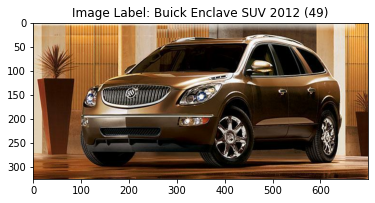

In [ ]:
image, label = cars_train.as_numpy_iterator().next()
plot_single_example(image, label)

### Split Train and Test Data Sets by 80/20 Ratio

In [ ]:
from sklearn.model_selection import train_test_split


# Load the entire dataset

cars_dataset = tfds.load('Cars196', as_supervised=True, shuffle_files=True, split='train+test')

# Get the total number of samples in the dataset
num_samples = tf.data.experimental.cardinality(cars_dataset).numpy()

# Calculate the sizes of the training and testing sets
train_size = int(0.8 * num_samples)
test_size = num_samples - train_size

# Split the dataset into training and testing sets
cars_train = cars_dataset.take(train_size)
cars_test = cars_dataset.skip(train_size)

print(train_size)
print(test_size)

12948
3237


### Resize All Images To a Fixed Size

In [ ]:
def preprocess_image(image, label):
    # Convert the image to float32 and scale it to [0, 1]
    image = tf.cast(image, tf.float32) / 255.0
    # Resize the image to 224x224
    image = tf.image.resize(image, (224, 224))
    return image, label

In [ ]:
batch_size = 32
cars_train = cars_train.map(preprocess_image).batch(batch_size)
cars_test = cars_test.map(preprocess_image).batch(batch_size)

### Data Augmentation

In [ ]:
%%script echo skipping
# Define the Inception Augmentation transformations
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(factor=0.1),
    tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.1, width_factor=0.1)
])

# Apply the Inception Augmentation transformations
cars_train = cars_train.map(lambda x, y: (data_augmentation(x), y))

# Transfer Learning Architecture

In this section we use Transfer Learning to solve our multiclass classification.


##Base model

For the base model we chose to use the pretrained model 'InceptionV3'.
We believe that the first 3 layers of 'InceptionV3' are relevant to our problem even when trained on imagenet, thus we decided to freeze the weights of the first 23 layers and only train the rest.

### Building the network

In [ ]:
%%script echo skipping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam

inputs = tf.keras.Input(shape=((224, 224, 3)));

pretrained_model = tf.keras.applications.InceptionV3(
                    input_tensor=inputs,
                    include_top=True,
                    weights='imagenet')

last_layer = pretrained_model.layers[-2].output
output = Flatten()(last_layer)
output = Dense(196, activation='softmax',name = 'ouput')(last_layer)

TLmodel = tf.keras.Model(inputs = inputs, outputs = output)


for layer in TLmodel.layers[:-25]:
  layer.trainable=False

#opt
opt = Adam(learning_rate=0.001)

#callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=2
)

TLmodel.build(input_shape=inputs.shape)

TLmodel.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

TLmodel.summary()

###Train

In [ ]:
%%script echo skipping
num_epochs = 20
#Train the model on the training set
TLhistory = TLmodel.fit(cars_train, epochs=num_epochs, validation_data=cars_test,callbacks=callback)

TLmodel.save("/content/gdrive/My Drive/12-3-23 models/TLmodel")

Epoch 1/20
405/405 [==============================] - 70s 163ms/step - loss: 4.3537 - sparse_categorical_accuracy: 0.1119 - val_loss: 3.3178 - val_sparse_categorical_accuracy: 0.2141
Epoch 2/20
405/405 [==============================] - 65s 160ms/step - loss: 3.1030 - sparse_categorical_accuracy: 0.2668 - val_loss: 2.8725 - val_sparse_categorical_accuracy: 0.2913
Epoch 3/20
405/405 [==============================] - 65s 160ms/step - loss: 2.5776 - sparse_categorical_accuracy: 0.3730 - val_loss: 2.6555 - val_sparse_categorical_accuracy: 0.3389
Epoch 4/20
405/405 [==============================] - 65s 159ms/step - loss: 2.2437 - sparse_categorical_accuracy: 0.4432 - val_loss: 2.4422 - val_sparse_categorical_accuracy: 0.3812
Epoch 5/20
405/405 [==============================] - 65s 160ms/step - loss: 2.0118 - sparse_categorical_accuracy: 0.4880 - val_loss: 2.4407 - val_sparse_categorical_accuracy: 0.3945
Epoch 6/20
405/405 [==============================] - 65s 160ms/step - loss: 1.8080 -

### Evaluation

102/102 [==============================] - 17s 38ms/step - loss: 2.2686 - sparse_categorical_accuracy: 0.4513
Test accuracy: 0.451343834400177


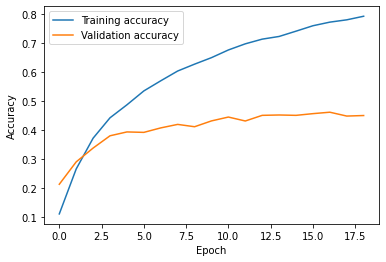

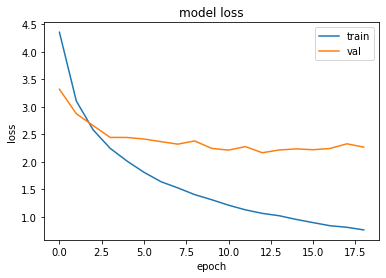

In [ ]:
%%script echo skipping
# Evaluate the model on the test set
test_loss, test_acc = TLmodel.evaluate(cars_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy over time
plt.plot(TLhistory.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(TLhistory.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(TLhistory.history['loss'])
plt.plot(TLhistory.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn

test_labels = np.array([])
test_preds = np.array([])
for image, label in cars_test:
  test_preds = np.concatenate([test_preds,np.argmax(TLmodel.predict(image),axis=-1)])
  test_labels = np.concatenate([test_labels,label.numpy()])


print("accuracy_score - ")
print(accuracy_score(test_labels, test_preds))
print("classification_report - ")
print(classification_report(test_labels, test_preds))

1/1 [==============================] - 1s 1s/step
accuracy_score - 
0.45165276490577694
classification_report - 
              precision    recall  f1-score   support

         0.0       0.87      0.81      0.84        16
         1.0       1.00      0.18      0.31        11
         2.0       0.64      0.69      0.67        13
         3.0       0.31      0.24      0.27        17
         4.0       0.33      0.08      0.12        13
         5.0       0.83      0.26      0.40        19
         6.0       1.00      0.27      0.42        15
         7.0       0.25      0.40      0.31        15
         8.0       0.50      0.33      0.40        24
         9.0       0.43      0.35      0.39        17
        10.0       0.30      0.93      0.46        14
        11.0       0.26      0.54      0.35        13
        12.0       0.38      0.50      0.43        16
        13.0       0.18      0.12      0.15        16
        14.0       0.70      0.41      0.52        17
        15.0       0.5

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Experiment 1: Change of the transferred model

In this experiment we decided to change our pretrained model of choice. We decided to use the 'InceptionResNetV2' model. This model uses residual blocks in its architecture which help negate the performance degradation problem that exists in deep neural networks, and thus allowing it to have more layers.
In this experiment we decided to freeze the first 24 layers as we think those could be relevant to our problem

### Building the network

In [ ]:
%%script echo skipping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam

inputs = tf.keras.Input(shape=((224, 224, 3)));

pretrained_model = tf.keras.applications.InceptionResNetV2(
                    input_tensor=inputs,
                    include_top=True,
                    weights='imagenet')

last_layer = pretrained_model.layers[-2].output
output = Flatten()(last_layer)
output = Dense(196, activation='softmax',name = 'ouput')(last_layer)

TLmodel2 = tf.keras.Model(inputs = inputs, outputs = output)


for layer in TLmodel2.layers[:-140]:
  layer.trainable=False

#opt
opt = Adam(learning_rate=0.001)

#callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=2
)

TLmodel2.build(input_shape=inputs.shape)

TLmodel2.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

TLmodel2.summary()

### Train

In [ ]:
%%script echo skipping
num_epochs = 20
#Train the model on the training set
TLhistory2 = TLmodel2.fit(cars_train, epochs=num_epochs, validation_data=cars_test,callbacks=callback)

TLmodel2.save("/content/gdrive/My Drive/12-3-23 models/TLmodel2")

Epoch 1/20
405/405 [==============================] - 88s 188ms/step - loss: 4.5011 - sparse_categorical_accuracy: 0.0666 - val_loss: 4.2708 - val_sparse_categorical_accuracy: 0.1050
Epoch 2/20
405/405 [==============================] - 69s 171ms/step - loss: 2.5982 - sparse_categorical_accuracy: 0.3428 - val_loss: 2.0400 - val_sparse_categorical_accuracy: 0.4714
Epoch 3/20
405/405 [==============================] - 68s 167ms/step - loss: 1.5843 - sparse_categorical_accuracy: 0.5713 - val_loss: 2.1921 - val_sparse_categorical_accuracy: 0.4714
Epoch 4/20
405/405 [==============================] - 68s 167ms/step - loss: 1.1214 - sparse_categorical_accuracy: 0.6910 - val_loss: 1.3848 - val_sparse_categorical_accuracy: 0.6104
Epoch 5/20
405/405 [==============================] - 68s 167ms/step - loss: 0.8636 - sparse_categorical_accuracy: 0.7641 - val_loss: 1.4367 - val_sparse_categorical_accuracy: 0.6108
Epoch 6/20
405/405 [==============================] - 68s 167ms/step - loss: 0.6804 -

### Evaluation

102/102 [==============================] - 19s 54ms/step - loss: 1.2989 - sparse_categorical_accuracy: 0.6824
Test accuracy: 0.6824219822883606


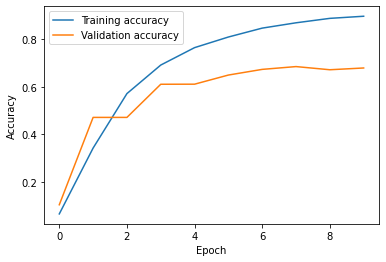

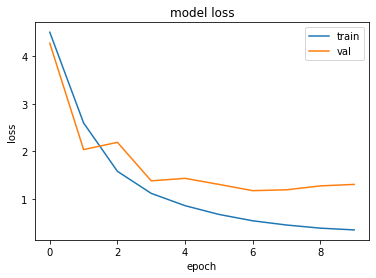

In [ ]:
%%script echo skipping
# Evaluate the model on the test set
test_loss, test_acc = TLmodel2.evaluate(cars_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy over time
plt.plot(TLhistory2.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(TLhistory2.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(TLhistory2.history['loss'])
plt.plot(TLhistory2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn

test_labels = np.array([])
test_preds = np.array([])
for image, label in cars_test:
  test_preds = np.concatenate([test_preds,np.argmax(TLmodel2.predict(image),axis=-1)])
  test_labels = np.concatenate([test_labels,label.numpy()])


print("accuracy_score - ")
print(accuracy_score(test_labels, test_preds))
print("classification_report - ")
print(classification_report(test_labels, test_preds))

1/1 [==============================] - 4s 4s/step
accuracy_score - 
0.6805684275563794
classification_report - 
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94        16
         1.0       0.37      0.78      0.50         9
         2.0       0.83      0.77      0.80        13
         3.0       0.67      0.82      0.74        17
         4.0       0.75      0.69      0.72        13
         5.0       1.00      0.45      0.62        20
         6.0       0.89      0.57      0.70        14
         7.0       0.44      0.47      0.45        15
         8.0       0.62      0.21      0.31        24
         9.0       1.00      0.18      0.30        17
        10.0       0.46      0.92      0.62        13
        11.0       0.71      0.38      0.50        13
        12.0       0.55      0.75      0.63        16
        13.0       0.36      0.56      0.44        16
        14.0       0.80      0.47      0.59        17
        15.0       0.91

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##Experiment 2: Change of trainable layers

In this experiment we decided to change the amount of trainable layers in the pretrained model. We believe its possible that decreasing the amount of trainable layers might have a positive effect on our model's performance. we think that leaving so many layers as trainable contributes to the confusion of the model as it has more variables to train while still having pretty minimal amount of data from our data base, and its possible that more layers of the pretrained model can be applicable to our problem. thus we decided to decrease the amount of trainable layers from 140 to 80 

### Building the network

In [ ]:
%%script echo skipping
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam

inputs = tf.keras.Input(shape=((224, 224, 3)));

pretrained_model = tf.keras.applications.InceptionResNetV2(
                    input_tensor=inputs,
                    include_top=True,
                    weights='imagenet')

last_layer = pretrained_model.layers[-2].output
output = Flatten()(last_layer)
output = Dense(196, activation='softmax',name = 'ouput')(last_layer)

TLmodel3 = tf.keras.Model(inputs = inputs, outputs = output)


for layer in TLmodel3.layers[:-80]:
  layer.trainable=False

#opt
opt = Adam(learning_rate=0.001)

#callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=2
)

TLmodel3.build(input_shape=inputs.shape)

TLmodel3.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

TLmodel3.summary()

### Train

In [ ]:
%%script echo skipping
num_epochs = 20
#Train the model on the training set
TLhistory3 = TLmodel3.fit(cars_train, epochs=num_epochs, validation_data=cars_test,callbacks=callback)

TLmodel3.save("/content/gdrive/My Drive/12-3-23 models/TLmodel3")

Epoch 1/20
405/405 [==============================] - 83s 177ms/step - loss: 3.6397 - sparse_categorical_accuracy: 0.1995 - val_loss: 2.4475 - val_sparse_categorical_accuracy: 0.3621
Epoch 2/20
405/405 [==============================] - 68s 169ms/step - loss: 1.9410 - sparse_categorical_accuracy: 0.4991 - val_loss: 1.7624 - val_sparse_categorical_accuracy: 0.5394
Epoch 3/20
405/405 [==============================] - 69s 169ms/step - loss: 1.3421 - sparse_categorical_accuracy: 0.6388 - val_loss: 1.5494 - val_sparse_categorical_accuracy: 0.5863
Epoch 4/20
405/405 [==============================] - 68s 168ms/step - loss: 0.9876 - sparse_categorical_accuracy: 0.7299 - val_loss: 1.4594 - val_sparse_categorical_accuracy: 0.5984
Epoch 5/20
405/405 [==============================] - 68s 168ms/step - loss: 0.7725 - sparse_categorical_accuracy: 0.7876 - val_loss: 1.6254 - val_sparse_categorical_accuracy: 0.5777
Epoch 6/20
405/405 [==============================] - 69s 169ms/step - loss: 0.6464 -

### Evaluation

102/102 [==============================] - 19s 53ms/step - loss: 1.3449 - sparse_categorical_accuracy: 0.6602
Test accuracy: 0.6601791977882385


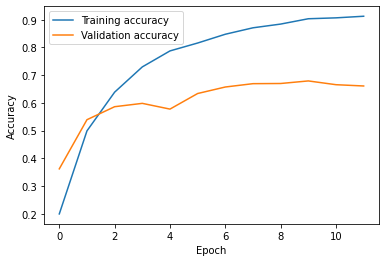

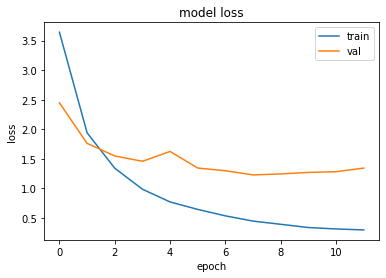

In [ ]:
%%script echo skipping
# Evaluate the model on the test set
test_loss, test_acc = TLmodel3.evaluate(cars_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy over time
plt.plot(TLhistory3.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(TLhistory3.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(TLhistory3.history['loss'])
plt.plot(TLhistory3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn

test_labels = np.array([])
test_preds = np.array([])
for image, label in cars_test:
  test_preds = np.concatenate([test_preds,np.argmax(TLmodel3.predict(image),axis=-1)])
  test_labels = np.concatenate([test_labels,label.numpy()])


print("accuracy_score - ")
print(accuracy_score(test_labels, test_preds))
print("classification_report - ")
print(classification_report(test_labels, test_preds))

1/1 [==============================] - 4s 4s/step
accuracy_score - 
0.6620327463700958
classification_report - 
              precision    recall  f1-score   support

         0.0       1.00      0.53      0.69        17
         1.0       0.75      0.33      0.46         9
         2.0       0.68      1.00      0.81        13
         3.0       1.00      0.59      0.74        17
         4.0       0.46      0.50      0.48        12
         5.0       1.00      0.30      0.46        20
         6.0       0.62      0.71      0.67        14
         7.0       0.50      0.75      0.60        16
         8.0       0.64      0.58      0.61        24
         9.0       0.86      0.33      0.48        18
        10.0       0.90      0.64      0.75        14
        11.0       0.56      0.38      0.45        13
        12.0       0.60      0.60      0.60        15
        13.0       0.67      0.25      0.36        16
        14.0       1.00      0.29      0.45        17
        15.0       0.75

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Image Retrieval

## Base model

Using the input and output of the layer before the output layer of the model from the previous part for the KNN architecture. Extracting features from the images and training a KNN model n features vectors of each image

### Building the network

In [ ]:
%%script echo skipping
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.models import Model
import numpy as np
from sklearn.metrics import accuracy_score

model = load_model('/content/TLmodel2')

# Load the test images and their labels
test_images, test_labels = [], []
for image, label in cars_test:
    test_images.append(image)
    test_labels.append(label)
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Load the training images and their labels
train_images, train_labels = [], []
for image, label in cars_train:
    train_images.append(image)
    train_labels.append(label)
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)


# Create embedding layer
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

# Compute the feature vectors for the training images
train_feature_vectors = embedding_layer.predict(train_images)
train_feature_vectors = train_feature_vectors / np.linalg.norm(train_feature_vectors, axis=1, keepdims=True)

# Compute the feature vectors for the test images
test_feature_vectors = embedding_layer.predict(test_images)
test_feature_vectors = test_feature_vectors / np.linalg.norm(test_feature_vectors, axis=1, keepdims=True)


102/102 [==============================] - 5s 49ms/step


### Train

In [ ]:
%%script echo skipping
# Fit the KNN classifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_feature_vectors, train_labels)

# Predict the labels for the train and test images
train_predictions = knn.predict(train_feature_vectors)
test_predictions = knn.predict(test_feature_vectors)

### Evaluation

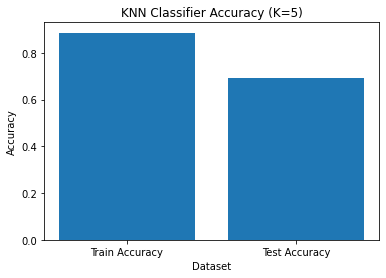

test_accuracy - 0.6929255483472351


['/content/gdrive/My Drive/12-3-23 models/KNNmodel.joblib']

In [ ]:
%%script echo skipping
# Compute the accuracy
train_accuracy = np.mean(train_predictions == train_labels)
test_accuracy = np.mean(test_predictions == test_labels)

plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title(f'KNN Classifier Accuracy (K={k})')
plt.show()
print(f"test_accuracy - {test_accuracy}")

dump(knn, '/content/gdrive/My Drive/12-3-23 models/KNNmodel.joblib')

## Experiment 1: Changing the distance metric of KNN

### Building the network

Changing the KNN's distance matric from the default 'minkowski' to 'cosine'

In [ ]:
%%script echo skipping
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras.models import Model
import numpy as np
from sklearn.metrics import accuracy_score
from joblib import dump

model = load_model('/content/TLmodel2')

# Load the test images and their labels
test_images, test_labels = [], []
for image, label in cars_test:
    test_images.append(image)
    test_labels.append(label)
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Load the training images and their labels
train_images, train_labels = [], []
for image, label in cars_train:
    train_images.append(image)
    train_labels.append(label)
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)


# Create embedding layer
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

# Compute the feature vectors for the training images
train_feature_vectors = embedding_layer.predict(train_images)
train_feature_vectors = train_feature_vectors / np.linalg.norm(train_feature_vectors, axis=1, keepdims=True)

# Compute the feature vectors for the test images
test_feature_vectors = embedding_layer.predict(test_images)
test_feature_vectors = test_feature_vectors / np.linalg.norm(test_feature_vectors, axis=1, keepdims=True)


102/102 [==============================] - 5s 51ms/step


### Train

In [ ]:
%%script echo skipping
# Fit the KNN classifier
k = 5
knn2 = KNeighborsClassifier(n_neighbors=k, metric='cosine')
knn2.fit(train_feature_vectors, train_labels)

# Predict the labels for the train and test images
train_predictions = knn2.predict(train_feature_vectors)
test_predictions = knn2.predict(test_feature_vectors)


### Evaluation

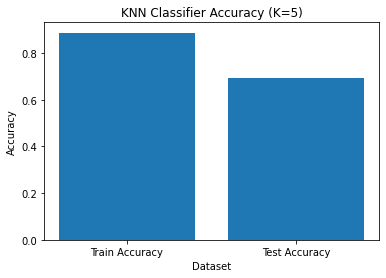

test_accuracy - 0.691998764287921


['/content/gdrive/My Drive/12-3-23 models/KNNmodel2.joblib']

In [ ]:
%%script echo skipping
# Compute the accuracy
train_accuracy = np.mean(train_predictions == train_labels)
test_accuracy = np.mean(test_predictions == test_labels)

plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title(f'KNN Classifier Accuracy (K={k})')
plt.show()
print(f"test_accuracy - {test_accuracy}")

# Save the KNN classifier
dump(knn, '/content/gdrive/My Drive/12-3-23 models/KNNmodel2.joblib')

## Experiment 2: Changing K value of KNN

Evaluating different number of neighbors (k) and training with the one which has the highest test accuracy

### Building the network and evaluating best 'k' number

We iterate through different 'k' values to evaluate and the optimal value

102/102 [==============================] - 5s 50ms/step


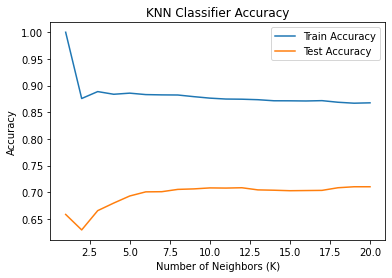

In [ ]:
%%script echo skipping
model = load_model('/content/TLmodel2')

# Load the test images and their labels
test_images, test_labels = [], []
for image, label in cars_test:
    test_images.append(image)
    test_labels.append(label)
test_images = np.concatenate(test_images)
test_labels = np.concatenate(test_labels)

# Load the training images and their labels
train_images, train_labels = [], []
for image, label in cars_train:
    train_images.append(image)
    train_labels.append(label)
train_images = np.concatenate(train_images)
train_labels = np.concatenate(train_labels)


# Create embedding layer
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

# Compute the feature vectors for the training images
train_feature_vectors = embedding_layer.predict(train_images)
train_feature_vectors = train_feature_vectors / np.linalg.norm(train_feature_vectors, axis=1, keepdims=True)

# Compute the feature vectors for the test images
test_feature_vectors = embedding_layer.predict(test_images)
test_feature_vectors = test_feature_vectors / np.linalg.norm(test_feature_vectors, axis=1, keepdims=True)

train_accuracies = []
test_accuracies = []
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_feature_vectors, train_labels)
    train_predictions = knn.predict(train_feature_vectors)
    test_predictions = knn.predict(test_feature_vectors)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.plot(range(1, 21), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 21), test_accuracies, label='Test Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.ylabel('Accuracy')
plt.title('KNN Classifier Accuracy')
plt.legend()
plt.show()

After we found the 'k' value with the best test accuracy, we train the KNN model using the 'k' we found earlier

### Train

In [ ]:
%%script echo skipping
# Fit the KNN classifier with k=20 which has the best test accuracy
k = 20
knn3 = KNeighborsClassifier(n_neighbors=k)
knn3.fit(train_feature_vectors, train_labels)

# Predict the labels for the train and test images
train_predictions = knn3.predict(train_feature_vectors)
test_predictions = knn3.predict(test_feature_vectors)

### Evaluation

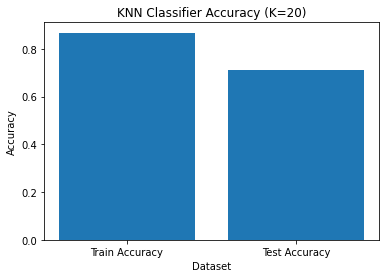

test_accuracy - 0.7102255174544331


['/content/gdrive/My Drive/12-3-23 models/KNNmodel3.joblib']

In [ ]:
%%script echo skipping
# Compute the accuracy
train_accuracy = np.mean(train_predictions == train_labels)
test_accuracy = np.mean(test_predictions == test_labels)

plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy])
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title(f'KNN Classifier Accuracy (K={k})')
plt.show()
print(f"test_accuracy - {test_accuracy}")

dump(knn, '/content/gdrive/My Drive/12-3-23 models/KNNmodel3.joblib')

# CNN

In this section we set out to build out own CNN without the usage of transfer learning, we will create a new CNN and train it from scratch.

## Base model

For our base model we chose to keep it rather simple, we placed 8 convolution layers while making use of MaxPooling to reduce dimensions and extract the most dominant feature. We also made use of dropout layers to improve performance. Dropout layers will use different neurons for different examples while training thus creating almost a few separate networks which will come together at the end of training to form the final network, and as we know merging networks after training could improve performance

### Building the network

In [ ]:
%%script echo skipping
import keras
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam


num_epochs = 50

inputs = tf.keras.Input(shape=((224, 224, 3)))

layer = keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same',strides=1, input_shape=(224, 224, 3))(inputs)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(512, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
output = Dense(196, activation='softmax',name = 'ouput')(layer)

model = tf.keras.Model(inputs=inputs,outputs=output)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) # lr is 0.001 by default

#callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=10
)

### Train

In [ ]:
%%script echo skipping
# Train the model on the training set
history = model.fit(cars_train, epochs=num_epochs, validation_data=cars_test,callbacks=callback)

model.save("/content/gdrive/My Drive/12-3-23 models/CNNmodel")

Epoch 1/50
405/405 [==============================] - 79s 178ms/step - loss: 5.7971 - sparse_categorical_accuracy: 0.0120 - val_loss: 7.0699 - val_sparse_categorical_accuracy: 0.0059
Epoch 2/50
405/405 [==============================] - 71s 174ms/step - loss: 5.0139 - sparse_categorical_accuracy: 0.0304 - val_loss: 5.8821 - val_sparse_categorical_accuracy: 0.0253
Epoch 3/50
405/405 [==============================] - 71s 176ms/step - loss: 4.8495 - sparse_categorical_accuracy: 0.0451 - val_loss: 6.5904 - val_sparse_categorical_accuracy: 0.0120
Epoch 4/50
405/405 [==============================] - 71s 175ms/step - loss: 4.6834 - sparse_categorical_accuracy: 0.0581 - val_loss: 5.7530 - val_sparse_categorical_accuracy: 0.0269
Epoch 5/50
405/405 [==============================] - 71s 175ms/step - loss: 4.4925 - sparse_categorical_accuracy: 0.0775 - val_loss: 5.3329 - val_sparse_categorical_accuracy: 0.0504
Epoch 6/50
405/405 [==============================] - 70s 174ms/step - loss: 4.3099 -

### Evaluation

102/102 [==============================] - 17s 36ms/step - loss: 6.4434 - sparse_categorical_accuracy: 0.2342
Test accuracy: 0.2341674417257309


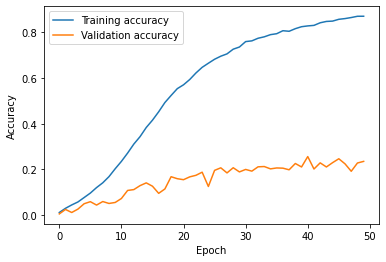

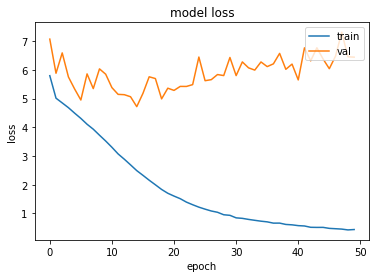

In [ ]:
%%script echo skipping
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(cars_test)
print('Test accuracy:', test_acc)


# Plot the training and validation accuracy over time
plt.plot(history.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn

test_labels = np.array([])
test_preds = np.array([])
for image, label in cars_test:
  test_preds = np.concatenate([test_preds,np.argmax(model.predict(image),axis=-1)])
  test_labels = np.concatenate([test_labels,label.numpy()])


print("accuracy_score - ")
print(accuracy_score(test_labels, test_preds))
print("classification_report - ")
print(classification_report(test_labels, test_preds))

1/1 [==============================] - 0s 36ms/step
accuracy_score - 
0.23787457522397282
classification_report - 
              precision    recall  f1-score   support

         0.0       0.50      0.41      0.45        17
         1.0       0.50      0.11      0.18         9
         2.0       0.33      0.23      0.27        13
         3.0       0.14      0.35      0.20        17
         4.0       0.00      0.00      0.00        12
         5.0       0.12      0.05      0.07        20
         6.0       0.26      0.36      0.30        14
         7.0       0.14      0.27      0.18        15
         8.0       0.14      0.38      0.20        24
         9.0       0.00      0.00      0.00        17
        10.0       0.21      0.86      0.34        14
        11.0       0.20      0.15      0.17        13
        12.0       0.13      0.13      0.13        15
        13.0       0.00      0.00      0.00        16
        14.0       0.25      0.12      0.16        17
        15.0       0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Experiment 1: Adding residual blocks

In this experiment we decided to incorporate some residual blocks in our network to try and minimize performance degradation as a result of using a large amount of layers

### Building the network

In [ ]:
%%script echo skipping
import keras
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam


num_epochs = 50

inputs = tf.keras.Input(shape=((224, 224, 3)))

layer = keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same',strides=1, input_shape=(224, 224, 3))(inputs)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)


skip_1 = layer

layer = keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)

skip_1 = keras.layers.MaxPooling2D((2, 2))(skip_1)
skip_1 = keras.layers.Conv2D(128, (1, 1), activation='relu',padding='same',strides=1)(skip_1)
skip_2 = keras.layers.Add()([skip_1,layer])


layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(skip_2)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)

skip_2 = keras.layers.Conv2D(256, (1, 1), activation='relu',padding='same',strides=1)(skip_2)
skip_3 = keras.layers.Add()([skip_2,layer])


layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(skip_3)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)

skip_3 = keras.layers.MaxPooling2D((2, 2))(skip_3)
skip_4 = keras.layers.Add()([skip_3,layer])


layer = keras.layers.Conv2D(512, (3, 3), activation='relu',padding='same',strides=1)(skip_4)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)

skip_4 = keras.layers.Conv2D(512, (1, 1), activation='relu',padding='same',strides=1)(skip_4)
skip_5 = keras.layers.Add()([skip_4,layer])


layer = keras.layers.Conv2D(512, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)


skip_5 = keras.layers.MaxPooling2D((2, 2))(skip_5)
skip_6 = keras.layers.Add()([skip_5,layer])


layer = keras.layers.Conv2D(512, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = Dropout(.2)(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)


skip_6 = keras.layers.MaxPooling2D((2, 2))(skip_6)
out = keras.layers.Add()([skip_6,layer])


layer = Flatten()(out)
output = Dense(196, activation='softmax',name = 'ouput')(layer)

model2 = tf.keras.Model(inputs=inputs,outputs=output)

# Compile the model
model2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) # lr is 0.001 by default

#callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=10
)

### Train

In [ ]:
%%script echo skipping
# Train the model on the training set
history2 = model2.fit(cars_train, epochs=num_epochs, validation_data=cars_test,callbacks=callback)

model2.save("/content/gdrive/My Drive/12-3-23 models/CNNmodel2")

Epoch 1/50
405/405 [==============================] - 80s 180ms/step - loss: 6.9376 - sparse_categorical_accuracy: 0.0114 - val_loss: 10.9794 - val_sparse_categorical_accuracy: 0.0040
Epoch 2/50
405/405 [==============================] - 72s 178ms/step - loss: 5.0855 - sparse_categorical_accuracy: 0.0276 - val_loss: 7.9172 - val_sparse_categorical_accuracy: 0.0059
Epoch 3/50
405/405 [==============================] - 72s 178ms/step - loss: 4.8902 - sparse_categorical_accuracy: 0.0418 - val_loss: 6.9953 - val_sparse_categorical_accuracy: 0.0145
Epoch 4/50
405/405 [==============================] - 72s 177ms/step - loss: 4.7279 - sparse_categorical_accuracy: 0.0589 - val_loss: 6.7405 - val_sparse_categorical_accuracy: 0.0275
Epoch 5/50
405/405 [==============================] - 73s 179ms/step - loss: 4.5777 - sparse_categorical_accuracy: 0.0746 - val_loss: 6.7944 - val_sparse_categorical_accuracy: 0.0327
Epoch 6/50
405/405 [==============================] - 73s 179ms/step - loss: 4.4160 

### Evaluation

102/102 [==============================] - 17s 37ms/step - loss: 11.8532 - sparse_categorical_accuracy: 0.1585
Test accuracy: 0.15848007798194885


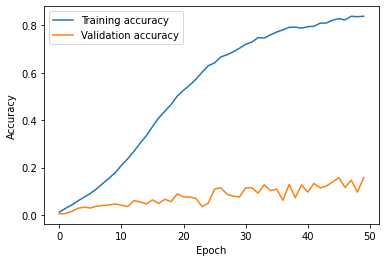

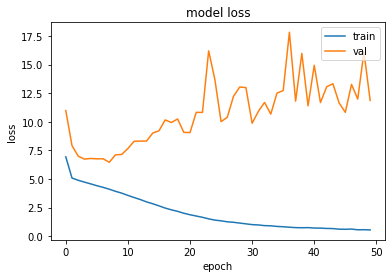

In [ ]:
%%script echo skipping
# Evaluate the model on the test set
test_loss, test_acc = model2.evaluate(cars_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy over time
plt.plot(history2.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history2.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn

test_labels = np.array([])
test_preds = np.array([])
for image, label in cars_test:
  test_preds = np.concatenate([test_preds,np.argmax(model2.predict(image),axis=-1)])
  test_labels = np.concatenate([test_labels,label.numpy()])


print("accuracy_score - ")
print(accuracy_score(test_labels, test_preds))
print("classification_report - ")
print(classification_report(test_labels, test_preds))

1/1 [==============================] - 0s 242ms/step
accuracy_score - 
0.15940685820203893
classification_report - 
              precision    recall  f1-score   support

         0.0       0.60      0.19      0.29        16
         1.0       0.03      0.10      0.04        10
         2.0       0.00      0.00      0.00        13
         3.0       0.04      0.06      0.05        17
         4.0       0.22      0.33      0.27        12
         5.0       0.40      0.10      0.16        20
         6.0       0.05      0.20      0.08        15
         7.0       0.11      0.13      0.12        15
         8.0       0.29      0.08      0.13        24
         9.0       0.10      0.24      0.14        17
        10.0       0.18      0.92      0.30        13
        11.0       0.00      0.00      0.00        13
        12.0       0.00      0.00      0.00        15
        13.0       0.20      0.06      0.10        16
        14.0       0.05      0.06      0.06        17
        15.0       

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Experiment 2: Remove dropout layers

In this experiment we decided to remove all the dropout layers, We wanted to examine their efficacy for our problem and make sure they weren't just introducing redundant complexity

### Building the network

In [ ]:
%%script echo skipping
import keras
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.optimizers import Adam


num_epochs = 50

inputs = tf.keras.Input(shape=((224, 224, 3)))

layer = keras.layers.Conv2D(32, (3, 3), activation='relu',padding='same',strides=1, input_shape=(224, 224, 3))(inputs)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(512, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same',strides=1)(layer)
layer = keras.layers.BatchNormalization()(layer)
layer = keras.layers.MaxPooling2D((2, 2))(layer)
layer = Flatten()(layer)
output = Dense(196, activation='softmax',name = 'ouput')(layer)

model3 = tf.keras.Model(inputs=inputs,outputs=output)

# Compile the model
model3.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]) # lr is 0.001 by default

#callback
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_sparse_categorical_accuracy",
    patience=10
)

### Train

In [ ]:
%%script echo skipping
# Train the model on the training set
history3 = model3.fit(cars_train, epochs=num_epochs, validation_data=cars_test,callbacks=callback)

model3.save("/content/gdrive/My Drive/12-3-23 models/CNNmodel3")

Epoch 1/50
405/405 [==============================] - 73s 166ms/step - loss: 5.7559 - sparse_categorical_accuracy: 0.0130 - val_loss: 5.4043 - val_sparse_categorical_accuracy: 0.0127
Epoch 2/50
405/405 [==============================] - 67s 165ms/step - loss: 5.0052 - sparse_categorical_accuracy: 0.0337 - val_loss: 5.9007 - val_sparse_categorical_accuracy: 0.0130
Epoch 3/50
405/405 [==============================] - 67s 166ms/step - loss: 4.8107 - sparse_categorical_accuracy: 0.0482 - val_loss: 6.5945 - val_sparse_categorical_accuracy: 0.0117
Epoch 4/50
405/405 [==============================] - 68s 167ms/step - loss: 4.6346 - sparse_categorical_accuracy: 0.0660 - val_loss: 6.3739 - val_sparse_categorical_accuracy: 0.0173
Epoch 5/50
405/405 [==============================] - 67s 166ms/step - loss: 4.4281 - sparse_categorical_accuracy: 0.0870 - val_loss: 5.7964 - val_sparse_categorical_accuracy: 0.0290
Epoch 6/50
405/405 [==============================] - 67s 166ms/step - loss: 4.2592 -

### Evaluation

102/102 [==============================] - 17s 36ms/step - loss: 5.8575 - sparse_categorical_accuracy: 0.2317
Test accuracy: 0.2316960096359253


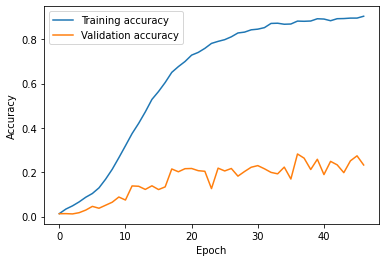

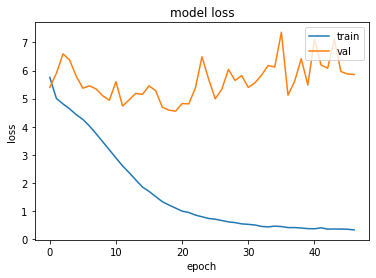

In [ ]:
%%script echo skipping
# Evaluate the model on the test set
test_loss, test_acc = model3.evaluate(cars_test)
print('Test accuracy:', test_acc)

# Plot the training and validation accuracy over time
plt.plot(history3.history['sparse_categorical_accuracy'], label='Training accuracy')
plt.plot(history3.history['val_sparse_categorical_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.show()

In [ ]:
%%script echo skipping
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import sklearn

test_labels = np.array([])
test_preds = np.array([])
for image, label in cars_test:
  test_preds = np.concatenate([test_preds,np.argmax(model3.predict(image),axis=-1)])
  test_labels = np.concatenate([test_labels,label.numpy()])


print("accuracy_score - ")
print(accuracy_score(test_labels, test_preds))
print("classification_report - ")
print(classification_report(test_labels, test_preds))

1/1 [==============================] - 0s 287ms/step
accuracy_score - 
0.23200494284831635
classification_report - 
              precision    recall  f1-score   support

         0.0       0.53      0.47      0.50        17
         1.0       0.00      0.00      0.00        11
         2.0       0.35      0.54      0.42        13
         3.0       0.14      0.12      0.13        17
         4.0       0.00      0.00      0.00        12
         5.0       0.22      0.26      0.24        19
         6.0       0.50      0.27      0.35        15
         7.0       0.04      0.20      0.06        15
         8.0       0.14      0.29      0.19        24
         9.0       0.10      0.12      0.11        16
        10.0       0.21      0.92      0.35        13
        11.0       0.04      0.08      0.05        13
        12.0       0.07      0.07      0.07        15
        13.0       0.50      0.12      0.20        16
        14.0       0.18      0.12      0.14        17
        15.0       

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Test Environments

# Transfer Learning Architecture

## Import libraries

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import pandas as pd
from google.colab import files
from matplotlib import pyplot as plt
from PIL import Image

## Load the model

In [ ]:
# Load the pre-trained model
model_path = '/content/TLmodel2'
model = load_model(model_path)

## Test

Saving Lamborghini_Aventador_LP700-4_Orange.jpg to Lamborghini_Aventador_LP700-4_Orange (16).jpg
Lamborghini_Aventador_LP700-4_Orange.jpg


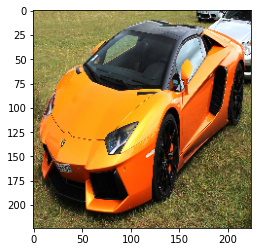

1/1 [==============================] - 0s 51ms/step
Predicted class label: Lamborghini Aventador Coupe 2012


In [ ]:
# Load the label dictionary
label_path = '/content/labels_dic.csv'
label_dic = pd.read_csv(label_path, header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

# Load and preprocess the test image
uploaded = files.upload()
for file in uploaded.keys():
    fileName = file
print(fileName)

img = image.load_img(file)

img = tf.cast(img, tf.float32) / 255.0
img = tf.image.resize(img, (224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(img)
plt.show()

# Make predictions on the test image
preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_label = label_dic[str(class_idx)]

# Print the predicted class label
print('Predicted class label:', class_label)

# Image Retrieval With KNN Architecture

## Import libraries

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.models import Model
import pandas as pd
from google.colab import files
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier
from joblib import dump, load

## Load Classifier and TLModel2

In [ ]:
# Load the KNN classifier and TLModel for the embedding layer
model = load_model('/content/TLmodel2')
knn = load('/content/KNNmodel3.joblib')

## Test

Saving 2021_Ferrari_F8_Tributo.jpg to 2021_Ferrari_F8_Tributo (1).jpg
2021_Ferrari_F8_Tributo.jpg


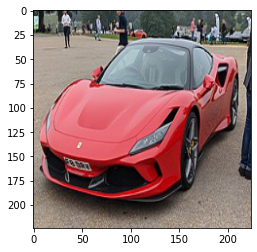

1/1 [==============================] - 0s 53ms/step
Predicted class label: Ferrari 458 Italia Coupe 2012


In [ ]:
# Load the label dictionary
label_path = '/content/labels_dic.csv'
label_dic = pd.read_csv(label_path, header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

# Load and preprocess the test image
uploaded = files.upload()
for file in uploaded.keys():
    fileName = file
print(fileName)

img = image.load_img(file)

img = tf.cast(img, tf.float32) / 255.0
img = tf.image.resize(img, (224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(img)
plt.show()

# Create embedding layer
embedding_layer = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

# Compute the feature vector for the new image
new_feature_vector = embedding_layer.predict(x)
new_feature_vector = new_feature_vector / np.linalg.norm(new_feature_vector, axis=1, keepdims=True)

# Predict the label for the new image
new_prediction = knn.predict(new_feature_vector)

# Make predictions on the test image

preds = model.predict(x)
class_idx = np.argmax(preds[0])
class_label = label_dic[str(class_idx)]

# Print the predicted class label
print('Predicted class label:', class_label)

# CNN Architecture

## Import libraries

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import pandas as pd
from google.colab import files
from matplotlib import pyplot as plt
from PIL import Image
from google.colab import drive

## Load the model

In [ ]:
# Load the pre-trained model
CNNmodel_path = '/content/CNNmodel'
CNNmodel = load_model(model_path)

## Test

Saving Fiat-Dolcevita-01-800x450.jpg to Fiat-Dolcevita-01-800x450 (1).jpg
Fiat-Dolcevita-01-800x450.jpg


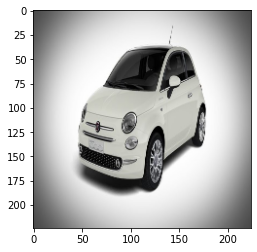

1/1 [==============================] - 0s 50ms/step
Predicted class label: FIAT 500 Convertible 2012


In [ ]:
# Load the label dictionary
label_path = '/content/labels_dic.csv'
label_dic = pd.read_csv(label_path, header=None, dtype={0: str}).set_index(0).squeeze().to_dict()

# Load and preprocess the test image
uploaded = files.upload()
for file in uploaded.keys():
    fileName = file
print(fileName)

img = image.load_img(file)

img = tf.cast(img, tf.float32) / 255.0
img = tf.image.resize(img, (224, 224))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

plt.imshow(img)
plt.show()

# Make predictions on the test image
preds = CNNmodel.predict(x)
class_idx = np.argmax(preds[0])
class_label = label_dic[str(class_idx)]

# Print the predicted class label
print('Predicted class label:', class_label)